# Домашнее задание № 9

### Задание 1 (5 баллов).
Это задание основано на этой тетрадке - https://github.com/mannefedov/compling_nlp_hse_course/blob/master/notebooks/transfer_learning_hg/Fine_tunining_pretrained_LMs.ipynb

Дообучите 3 предобученных модели на тех же данных, что и в семинаре. Сравните качество и выберите лучшую. 
Модели должны отличаться друг от друга не только параметрами ru/en/multilingual, base/large, cased/uncased. Все три выбранные модели должны работать лучше, чем бейзлайн без дообучения (т.е. если модель не работает, попробуйте другую).


In [15]:
! wget https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/master/notebooks/transfer_learning_hg/Fine_tune_pretrained_LM_torch.ipynb

--2024-03-13 21:58:35--  https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/master/notebooks/transfer_learning_hg/Fine_tune_pretrained_LM_torch.ipynb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74959 (73K) [text/plain]
Saving to: ‘Fine_tune_pretrained_LM_torch.ipynb’

Fine_tune_pretraine 100%[===================>]  73.20K  --.-KB/s    in 0.05s   

2024-03-13 21:58:35 (1.52 MB/s) - ‘Fine_tune_pretrained_LM_torch.ipynb’ saved [74959/74959]



In [13]:
! wget -O data/lenta_sample.csv https://github.com/mannefedov/compling_nlp_hse_course/raw/master/notebooks/transfer_learning_hg/lenta_sample.csv

--2024-03-13 20:51:24--  https://github.com/mannefedov/compling_nlp_hse_course/raw/master/notebooks/transfer_learning_hg/lenta_sample.csv
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/master/notebooks/transfer_learning_hg/lenta_sample.csv [following]
--2024-03-13 20:51:24--  https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/master/notebooks/transfer_learning_hg/lenta_sample.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1628490 (1.6M) [text/plain]
Saving to: ‘data/lenta_sample.csv’

data/lenta_sample.c 100%[===================>]   1.55

In [1]:
# стандартные библиотеки
import os, re
import numpy as np
from time import time
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import Counter
from string import punctuation
import matplotlib.pyplot as plt
%matplotlib inline


# pytortch и huggingface 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from transformers import AutoModel
from transformers import AutoTokenizer

In [2]:
data = pd.read_csv('data/lenta_sample.csv')
data.dropna(subset=['topic', 'text'], inplace=True)

In [3]:
data

,url,title,text,topic,tags,date
0,https://lenta.ru/news/2010/12/16/passports/,Московская милиция ужесточила паспортный режим,В Москве после серии массовых беспорядков на н...,Россия,Все,2010/12/16
1,https://lenta.ru/news/2014/05/19/student/,Московского студента ограбили на 6 миллионов р...,Неизвестные вынесли из квартиры московского ст...,Россия,NaN,2014/05/19
2,https://lenta.ru/news/2008/09/27/catch/,В Ставропольском крае обезврежены боевики,"В Ставропольском крае задержаны боевики, котор...",Россия,Все,2008/09/27
3,https://lenta.ru/news/2009/07/23/refuse/,Лужков отказался трудоустраивать китайцев с Че...,"Мэр Москвы Юрий Лужков заявил, что не намерен ...",Россия,Все,2009/07/23
4,https://lenta.ru/news/2012/09/29/factory/,По факту пожара на заводе в Югре заведено дело,Следственный комитет России возбудил уголовное...,Россия,Все,2012/09/29
...,...,...,...,...,...,...
602,https://lenta.ru/news/2014/09/14/pattern/,1914. Выкройки для раненых,"В дополнение к выкройкам белья для раненых, ра...",Библиотека,Первая мировая,2014/09/14
603,https://lenta.ru/news/2014/12/23/christmas/,1914. Немецкие и британские солдаты отметили п...,24 декабря в Бельгии в районе Ипра произошло н...,Библиотека,Первая мировая,2014/12/23
604,https://lenta.ru/news/2014/10/21/dobrovolec/,1914. Польский доброволец-герой,В числе поступивших в нашу армию добровольцев ...,Библиотека,Первая мировая,2014/10/21
605,https://lenta.ru/news/2014/09/18/postoffice/,1914. Письма в действующую армию на деревню де...,За последнее время на имя начальника штаба Вер...,Библиотека,Первая мировая,2014/09/18


In [4]:
NUM_CLASSES = 17

In [5]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, tokenizer, MAX_LEN, texts, targets):
        
        self.tokenizer = tokenizer
        self.texts = [torch.LongTensor(tokenizer.encode(t)[:MAX_LEN]) for t in texts]
        self.texts = torch.nn.utils.rnn.pad_sequence(self.texts, batch_first=True,
                                                     padding_value=self.tokenizer.pad_token_id)
        
        self.MAX_LEN = MAX_LEN
        self.length = len(texts)
        
        self.target = torch.LongTensor(targets)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        ids = self.texts[index]
        y = self.target[index]

        return ids, y


In [6]:
from sklearn.metrics import f1_score

def train(model, iterator, optimizer, criterion, print_every=1000):
    
    epoch_loss = []
    epoch_f1 = []
    
    model.train()  

    for i, (texts, ys) in enumerate(iterator):
        
        optimizer.zero_grad()   
        predictions = model(texts.to(device)).squeeze()  
        loss = criterion(predictions, ys.to(device))        
        
        
        
        loss.backward()
        optimizer.step()     
        preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
        y_true = ys.tolist()
        
        epoch_loss.append(loss.item())
        epoch_f1.append(f1_score(y_true, preds, average="micro"))
        
        if not (i+1) % print_every:
            print(f'Loss: {np.mean(epoch_loss)}; F1 measure: {np.mean(epoch_f1)}')
        
    return np.mean(epoch_f1)


def evaluate(model, iterator, criterion):
    
    epoch_loss = []
    epoch_f1 = []
    pred = []
    
    model.eval()  
    with torch.no_grad():
        for texts, ys in iterator:   

            predictions = model(texts.to(device)).squeeze()  
            loss = criterion(predictions, ys.to(device))        
            preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
            y_true = ys.tolist()
            

            epoch_loss.append(loss.item())  
            epoch_f1.append(f1_score(y_true, preds, average="micro"))
            pred.extend(preds)
            
    return np.mean(epoch_f1), pred

In [24]:
import gc

def free_memory():

    global model, optimizer
    
    del model
    del optimizer
    gc.collect()
    torch.cuda.empty_cache()

In [8]:
# # Rubert - от IPavlov
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")
model_bert = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased").to(torch.device('cuda'))

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
MAX_LEN = 512

In [10]:
texts = data.title.values
id2label = {i:l for i,l in enumerate(set(data.topic))}
label2id = {l:i for i,l in id2label.items()}
targets = [label2id[l] for l in data.topic]

In [11]:
train_texts, valid_texts, train_targets, valid_targets = train_test_split(texts, targets, test_size=0.05)

In [13]:
training_set = Dataset(tokenizer, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True, )
valid_set = Dataset(tokenizer, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=True)

In [14]:
class CLF(nn.Module):
    
    def __init__(self, pretrained_model, input_layer, coef, num_classes):
        super().__init__()          
        self.tokenizer = tokenizer # токенизатор
        self.pretrained_model = pretrained_model # предобученная модель
        #
        self.drop = nn.Dropout(0.4) # добавим дропаут чтобы не переобучалось
        self.fc = nn.Sequential(*[nn.Linear(input_layer, int(coef*input_layer)),
                                 nn.LayerNorm(int(coef*input_layer)),
                                nn.LeakyReLU(),
                                 nn.Linear(int(coef*input_layer), num_classes)])
        self.act = nn.LogSoftmax(1) 
        
    def forward(self, texts):
        
        mask = (texts != tokenizer.pad_token_id).long()
        
        # прогоняем через BERT
        hidden = self.pretrained_model(texts, attention_mask=mask)[0]
        
        dense_outputs=self.fc(self.drop(torch.mean(hidden, axis = 1)))
        outputs=self.act(dense_outputs)
        
        return outputs

In [345]:
free_memory()

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = CLF(model_bert, 768, 1.1, NUM_CLASSES)
# define different lr for base model and classifier
optimizer = optim.Adam([{'params': model.pretrained_model.parameters(), "lr": 1e-6},
                       {'params': model.fc.parameters(), 'lr': 1e-4}], 
                       amsgrad=True)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

In [16]:
EPOCHS = 30

In [17]:
evl, preds = evaluate(model, valid_generator, criterion)
print(f'No finetuning, Eval - {evl: .4f}')

No finetuning, Eval -  0.0646


In [18]:
f1s = []
f1s_eval = []

for i in range(EPOCHS):
    f1s.append(train(model, training_generator, optimizer, criterion, 400))
    evl, preds = evaluate(model, valid_generator, criterion)
    print(f'Epoch - {i}, Eval - {evl: .4f}')
    f1s_eval.append(evl)

Epoch - 0, Eval -  0.4875
Epoch - 1, Eval -  0.5104
Epoch - 2, Eval -  0.5500
Epoch - 3, Eval -  0.5875
Epoch - 4, Eval -  0.6167
Epoch - 5, Eval -  0.5792
Epoch - 6, Eval -  0.6167
Epoch - 7, Eval -  0.6458
Epoch - 8, Eval -  0.6500
Epoch - 9, Eval -  0.6438
Epoch - 10, Eval -  0.6125
Epoch - 11, Eval -  0.6062
Epoch - 12, Eval -  0.6104
Epoch - 13, Eval -  0.5792
Epoch - 14, Eval -  0.5750
Epoch - 15, Eval -  0.5437
Epoch - 16, Eval -  0.5813
Epoch - 17, Eval -  0.5813
Epoch - 18, Eval -  0.5813
Epoch - 19, Eval -  0.5396
Epoch - 20, Eval -  0.5813
Epoch - 21, Eval -  0.5437
Epoch - 22, Eval -  0.5500
Epoch - 23, Eval -  0.5813
Epoch - 24, Eval -  0.5479
Epoch - 25, Eval -  0.6104
Epoch - 26, Eval -  0.5521
Epoch - 27, Eval -  0.5458
Epoch - 28, Eval -  0.5500
Epoch - 29, Eval -  0.5521


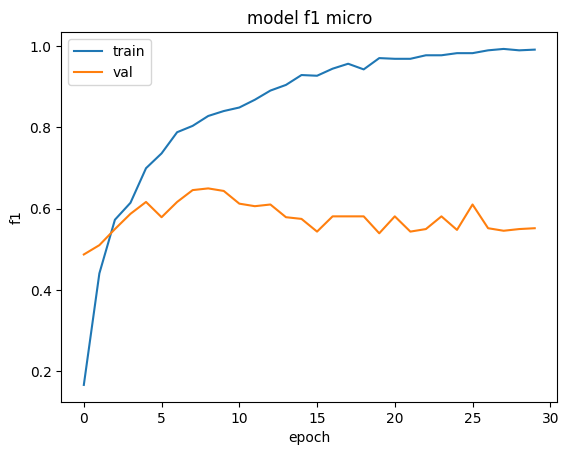

In [19]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
max(f1s_eval)

0.65

### let's try another model

In [21]:
from transformers import AutoTokenizer, AutoModelForPreTraining

tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
model_bert = AutoModelForPreTraining.from_pretrained("cointegrated/rubert-tiny")

In [22]:
model_bert

BertForPreTraining(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29564, 312, padding_idx=0)
      (position_embeddings): Embedding(512, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_

In [89]:
free_memory()

In [90]:
training_set = Dataset(tokenizer, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True, )
valid_set = Dataset(tokenizer, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=True)

In [91]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = CLF(model_bert.bert, 312, 0.1, NUM_CLASSES)
# define different lr for base model and classifier
optimizer = optim.Adam([{'params': model.pretrained_model.parameters(), "lr": 3e-7},
                       {'params': model.fc.parameters(), 'lr': 2e-3}], 
                        amsgrad = True)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

In [92]:
EPOCHS = 30

In [93]:
evl, preds = evaluate(model, valid_generator, criterion)
print(f'No finetuning, Eval - {evl: .4f}')

No finetuning, Eval -  0.0958


In [94]:
f1s = []
f1s_eval = []

for i in range(EPOCHS):
    f1s.append(train(model, training_generator, optimizer, criterion, 400))
    evl, preds = evaluate(model, valid_generator, criterion)
    print(f'Epoch - {i}, Eval - {evl: .4f}')
    f1s_eval.append(evl)

Epoch - 0, Eval -  0.3563
Epoch - 1, Eval -  0.3521
Epoch - 2, Eval -  0.3854
Epoch - 3, Eval -  0.3854
Epoch - 4, Eval -  0.3563
Epoch - 5, Eval -  0.3583
Epoch - 6, Eval -  0.3229
Epoch - 7, Eval -  0.2896
Epoch - 8, Eval -  0.2625
Epoch - 9, Eval -  0.3229
Epoch - 10, Eval -  0.2979
Epoch - 11, Eval -  0.3187
Epoch - 12, Eval -  0.2604
Epoch - 13, Eval -  0.2583
Epoch - 14, Eval -  0.3208
Epoch - 15, Eval -  0.3229
Epoch - 16, Eval -  0.2562
Epoch - 17, Eval -  0.3271
Epoch - 18, Eval -  0.3187
Epoch - 19, Eval -  0.3542
Epoch - 20, Eval -  0.3208
Epoch - 21, Eval -  0.3229
Epoch - 22, Eval -  0.2917
Epoch - 23, Eval -  0.2896
Epoch - 24, Eval -  0.3229
Epoch - 25, Eval -  0.3583
Epoch - 26, Eval -  0.3563
Epoch - 27, Eval -  0.3229
Epoch - 28, Eval -  0.3167
Epoch - 29, Eval -  0.3208


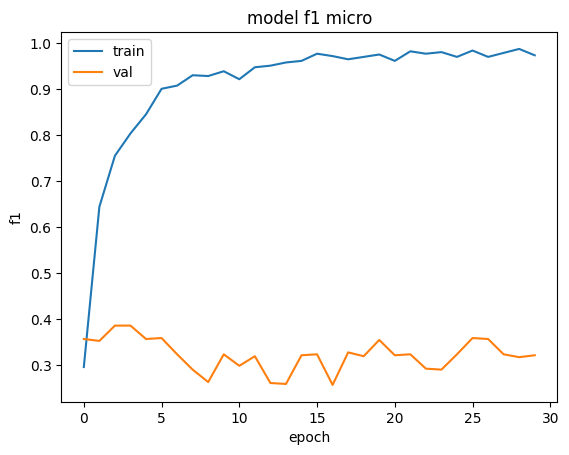

In [95]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [96]:
max(f1s_eval)

0.38541666666666663

### And another one

In [104]:
from transformers import AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("FacebookAI/xlm-roberta-base")
model_bert = AutoModelForMaskedLM.from_pretrained("FacebookAI/xlm-roberta-base")

Some weights of the model checkpoint at FacebookAI/xlm-roberta-base were not used when initializing XLMRobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [107]:
model_bert

XLMRobertaForMaskedLM(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
  

In [ ]:
free_memory()

In [108]:
training_set = Dataset(tokenizer, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True, )
valid_set = Dataset(tokenizer, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=True)

In [123]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = CLF(model_bert.roberta, 768, 1.5, NUM_CLASSES)
# define different lr for base model and classifier
optimizer = optim.Adam([{'params': model.pretrained_model.parameters(), "lr": 3e-8},
                       {'params': model.fc.parameters(), 'lr': 2e-3}], 
                        amsgrad = True)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

In [124]:
EPOCHS = 50

In [125]:
evl, preds = evaluate(model, valid_generator, criterion)
print(f'No finetuning, Eval - {evl: .4f}')

No finetuning, Eval -  0.0000


In [126]:
f1s = []
f1s_eval = []

for i in range(EPOCHS):
    f1s.append(train(model, training_generator, optimizer, criterion, 400))
    evl, preds = evaluate(model, valid_generator, criterion)
    print(f'Epoch - {i}, Eval - {evl: .4f}')
    f1s_eval.append(evl)

Epoch - 0, Eval -  0.3542
Epoch - 1, Eval -  0.5146
Epoch - 2, Eval -  0.5104
Epoch - 3, Eval -  0.5813
Epoch - 4, Eval -  0.6167
Epoch - 5, Eval -  0.4458
Epoch - 6, Eval -  0.5792
Epoch - 7, Eval -  0.7146
Epoch - 8, Eval -  0.5125
Epoch - 9, Eval -  0.6417
Epoch - 10, Eval -  0.5833
Epoch - 11, Eval -  0.6104
Epoch - 12, Eval -  0.6146
Epoch - 13, Eval -  0.5500
Epoch - 14, Eval -  0.5500
Epoch - 15, Eval -  0.5500
Epoch - 16, Eval -  0.5750
Epoch - 17, Eval -  0.5479
Epoch - 18, Eval -  0.5833
Epoch - 19, Eval -  0.5750
Epoch - 20, Eval -  0.5792
Epoch - 21, Eval -  0.6125
Epoch - 22, Eval -  0.6792
Epoch - 23, Eval -  0.5813
Epoch - 24, Eval -  0.6146
Epoch - 25, Eval -  0.6167
Epoch - 26, Eval -  0.5792
Epoch - 27, Eval -  0.6125
Epoch - 28, Eval -  0.6125
Epoch - 29, Eval -  0.6104
Epoch - 30, Eval -  0.6125
Epoch - 31, Eval -  0.6438
Epoch - 32, Eval -  0.5750
Epoch - 33, Eval -  0.6125
Epoch - 34, Eval -  0.6167
Epoch - 35, Eval -  0.6146
Epoch - 36, Eval -  0.6146
Epoch - 37,

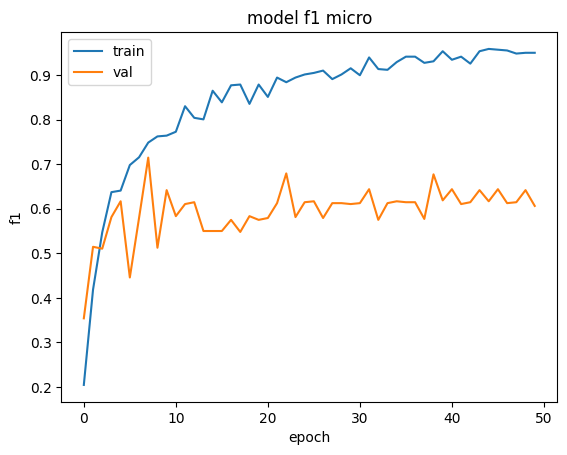

In [127]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [128]:
max(f1s_eval)

0.7145833333333333

In [129]:
free_memory()

### В целом, результат близок к результатам первой модели -- если поподбирать параметры инициализации, lr и слои, то в целом результат будет примерно идентичным -- понять больше по столь небольшому датасету будет уже весьма затруднительно

### Задание 2 (5 баллов).

Это задание основано на этой тетрадке - https://github.com/mannefedov/compling_nlp_hse_course/blob/master/notebooks/gpt/gpt.ipynb

Попробуйте дообучать GPT на каком-то другом тексте (можете попробовать любые стихи или какие-то специфичные вещи вроде анекдотов или репа). 
Попробуйте разные методы и параметры генерации (beam search, температура, top_k и тп). Сохраните в тетрадке несколько хороших сгенерированных текстов. 

Можете использовать другую модель.


In [2]:
! wget https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/master/notebooks/gpt/gpt.ipynb

--2024-03-10 23:54:03--  https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/master/notebooks/gpt/gpt.ipynb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 153697 (150K) [text/plain]
Saving to: ‘gpt.ipynb’

gpt.ipynb           100%[===================>] 150.09K  --.-KB/s    in 0.08s   

2024-03-10 23:54:04 (1.83 MB/s) - ‘gpt.ipynb’ saved [153697/153697]



In [1]:
from transformers.utils import logging

In [57]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
DEVICE = torch.device("cuda:0")

# Загружаем модель ruGPT от сбера

model_name_or_path = "Nehc/gpt2_lovecraft_ru"
tokenizer = GPT2Tokenizer.from_pretrained(model_name_or_path)
model = GPT2LMHeadModel.from_pretrained(model_name_or_path).to(DEVICE)

#### Попробуем погенерить лавкрафтианские стихи, почему бы и нет. Хотя возможно такие стихи скорее попортят генерацию -- как минимум в силу количества повторов

In [58]:
text = """
Мне жалко что я не зверь,
бегающий по синей дорожке,
говорящий себе поверь,
а другому себе подожди немножко,
мы выйдем с собой погулять в лес
для рассмотрения ничтожных листьев.
Мне жалко что я не звезда,
бегающая по небосводу,
в поисках точного гнезда
она находит себя и пустую земную воду,
никто не слыхал чтобы звезда издавала скрип,
ее назначение ободрять собственным молчанием рыб.
Еще есть у меня претензия,
что я не ковер, не гортензия.
Мне жалко что я не крыша,
распадающаяся постепенно,
которую дождь размачивает,
у которой смерть не мгновенна.
Мне не нравится что я смертен,
мне жалко что я неточен.
Многим многим лучше, поверьте,
частица дня единица ночи.
Мне жалко что я не орел,
перелетающий вершины и вершины,
которому на ум взбрел
человек, наблюдающий аршины.
Мы сядем с тобою ветер
на этот камушек смерти.
Мне жалко что я не чаша,
мне не нравится что я не жалость.
Мне жалко что я не роща,
которая листьями вооружалась.
Мне трудно что я с минутами,
меня они страшно запутали.
Мне невероятно обидно
что меня по-настоящему видно.
Еще есть у меня претензия,
что я не ковер, не гортензия.
Мне страшно что я двигаюсь
не так как жуки жуки,
как бабочки и коляски
и как жуки пауки.
Мне страшно что я двигаюсь
непохоже на червяка,
червяк прорывает в земле норы,
заводя с землей разговоры.
Земля где твои дела,
говорит ей холодный червяк,
а земля распоряжаясь покойниками,
может быть в ответ молчит,
она знает что все не так
Мне трудно что я с минутами,
они меня страшно запутали.
Мне страшно что я не трава трава,
мне страшно что я не свеча.
Мне страшно что я не свеча трава,
на это я отвечал,
и мигом качаются дерева.
Мне страшно что я при взгляде
на две одинаковые вещи
не замечаю что они различны,
что каждая живет однажды.
Мне страшно что я при взгляде
на две одинаковые вещи
не вижу что они усердно
стараются быть похожими.
Я вижу искаженный мир,
я слышу шепот заглушенных лир,
и тут за кончик буквы взяв,
я поднимаю слово шкаф,
теперь я ставлю шкаф на место,
он вещества крутое тесто
Мне не нравится что я смертен,
мне жалко что я не точен,
многим многим лучше, поверьте,
частица дня единица ночи
Еще есть у меня претензия,
что я не ковер, не гортензия.
Мы выйдем с собой погулять в лес
для рассмотрения ничтожных листьев,
мне жалко что на этих листьях
я не увижу незаметных слов,
называющихся случай, называющихся
бессмертие, называющихся вид основ
Мне жалко что я не орел,
перелетающий вершины и вершины,
которому на ум взбрел
человек, наблюдающий аршины.
Мне страшно что всё приходит в ветхость,
и я по сравнению с этим не редкость.
Мы сядем с тобою ветер
на этот камушек смерти.
Кругом как свеча возрастает трава,
и мигом качаются дерева.
Мне жалко что я семя,
мне страшно что я не тучность.
Червяк ползет за всеми,
он несет однозвучность.
Мне страшно что я неизвестность,
мне жалко что я не огонь.

"""

В huggingface уже реализованы все инструменты для дообучения. Даже если вы не знакомы с pytorch разобраться будет не сложно

In [59]:
from transformers import TextDataset, DataCollatorForLanguageModeling

# Сохраним обучающие данные в .txt файл 
train_path = 'train_dataset.txt'
with open(train_path, "w", encoding="utf-8") as f:
    f.write(text)

# Создание датасета
train_dataset = TextDataset( tokenizer=tokenizer,
                            file_path=train_path,
                            block_size=64, 
                            overwrite_cache=True)
  
# специальный класс который будет подавать в модель данные в нужном ей виде
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

### Попробуем лишь несколько сместить распределение дообучая пару эпох

In [83]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments( 
    output_dir= "./finetuned",
    overwrite_output_dir=True,
    num_train_epochs=30, 
    per_device_train_batch_size=32, 
    per_device_eval_batch_size=32,  
    gradient_accumulation_steps=16, 
    )


trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    optimizers = (torch.optim.Adam(model.parameters(),lr=3e-6),None) # Optimizer and lr scheduler
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [84]:
trainer.train()

Step,Training Loss


TrainOutput(global_step=30, training_loss=0.22027637163798014, metrics={'train_runtime': 4.3914, 'train_samples_per_second': 81.978, 'train_steps_per_second': 6.832, 'total_flos': 11758141440000.0, 'train_loss': 0.22027637163798014, 'epoch': 30.0})

In [72]:
text = '''Мой дядя самых честных правил,
Когда не в шутку занемог,
Он уважать себя заставил
И лучше выдумать не мог.
'''
input_ids = tokenizer.encode(text, return_tensors="pt").to(DEVICE)
model.eval()
with torch.no_grad():
    out = model.generate(input_ids, 
                        do_sample=True,
                        temperature=0.4,
                        top_k=40,
                        max_length=300,
                        repetition_penalty = 1.1
                        )

generated_text = list(map(tokenizer.decode, out))[0]
print()
print(generated_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Мой дядя самых честных правил,
Когда не в шутку занемог,
Он уважать себя заставил
И лучше выдумать не мог.
А теперь я вижу:
В доме одни лишь люди!
Я знаю, что мой дядя
Не только из тех, кто живет в лесу,
Но еще и из тех, кто живет на земле.
Я знаю, что он
Забывает о том, что он
Свой дом построил.
Я знаю, что он
Всех своих друзей обманул.
Я знаю, что он
Не хочет жить в этом мире.
Я знаю, что он
Потерял все, чего достиг.
Только я знаю,
Что он
Не может больше жить в этом мире.
Я знаю, что он
Некогда был великим,
Но теперь ему пора умирать.
Я знаю, что он
Не вернется к тому,
Чему его учили.
Он знает, что он
Той же ночью ушел.
Я знаю, что он
Сбежал от того,
Кто его учил.
Я знаю, что он
Ушел навсегда.
Я знаю, что он
Не вернется к тому,
Чему его учили.
Он знает, что он
Той же ночью ушел.
Я знаю, что он
Сбежал от того,
Кто его научил.
Я знаю, что он
Ушел навсегда.
Я знаю, что он
Не вернется


#### А вот это уже, конечно, забавно

In [77]:
text = "Пьяный геолог не засек ход тектонических плит "
input_ids = tokenizer.encode(text, return_tensors="pt").to(DEVICE)
model.eval()
with torch.no_grad():
    out = model.generate(input_ids, 
                        do_sample=True,
                        num_beams=7, top_k=40,
                         temperature = .7,
                        max_length=500, 
                         no_repeat_ngram_size=4
                        )

generated_text = list(map(tokenizer.decode, out))[0]
print()
print(generated_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Пьяный геолог не засек ход тектонических плит 
Пьяный археолог не нашел ход тектонической плиты 
Пьянствующий геолог не нашел хода тектонической плите 
Пятнадцатилетние геологи не нашли хода тектоническим плитам 
Пятьдесят лет назад в Аркхеме была найдена древняя пещера 
Пятидесятлетние археологи не нашли ход тектоническим плитам 
Десять лет назад в Антарктике была найдена древнейшая пещера в Антарктике 
Двенадцать лет назад в Северном Ледовитом океане была найдена самая древняя пещера в мире 
Девять лет назад в Тихом океане была обнаружена самая древняя в мире пещера в Мискатоникском заливе 
Девятнадцать лет назад в Индийском океане был найден самый древний в мире пещерный город 
Двадцать пять лет назад в Гренландии была найдена пещера в Гренландии 
Тридцать шесть лет назад в Новой Англии была найдена одна из самых древних в мире пещер 
Тридцатишестидесятые археологи не обнаружили ход тектоническими плитами 
Двадцатишестнадцатилетняя археология не нашла ход тектонические плитами 

Пя

In [90]:
text = "Пьяный геолог не засек ход тектонических плит "
input_ids = tokenizer.encode(text, return_tensors="pt").to(DEVICE)
model.eval()
with torch.no_grad():
    out = model.generate(input_ids, 
                        do_sample=True,
                        num_beams=8,
                         top_k=45,
                         temperature = .5,
                        max_length=500, 
                         no_repeat_ngram_size=6,
                         repetition_penalty = 1.3
                        )

generated_text = list(map(tokenizer.decode, out))[0]
print()
print(generated_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Пьяный геолог не засек ход тектонических плит 
Неизвестный геолог не заметил ход тектонических плит.
Неизвестные геологи не заметили ход тектонических плит,
Неизвестные ученые не заметили ход тектонической плиты,
Неизвестные физики не заметили хода тектонической плиты.
Неизвестные физики ничего не заметили,
Неизвестные математики ничего не заметили.
Неизвестные астрономы ничего не заметили,
Астрономы ничего не заметили.
Некрономикон ничего не заметил,
Некромант ничего не заметил.
Некрономикона ничего не видно,
Некроманта ничего не видно.
Некроманты ничего не заметили,
Некроманту ничего не видно.
Неизвестный астроном ничего не заметил,
Неизвестный математик ничего не заметил.
Неизвестный химик ничего не заметил,
Астроном ничего не заметил.
Неведомый физик ничего не заметил,
Неведомый химик ничего не заметил.
Несчастный геолог ничего не заметил,
Несчастный химик ничего не увидел,
Несчастный ученый ничего не заметил,
Непоседы ничего не заметили,
Несчастный философ ничего не заметил,
Недв